In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

sns.set()

### About dataset:

Kumpulan data ini menunjukkan berbagai spesifikasi dari 3000 tipe handpone.  

In [15]:
# Load the data
df = pd.read_csv('cellphone_price.csv')
# Check the data
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0
2996,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1
2997,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0
2998,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0


In [16]:
# Separate numerical and categorical features
num_cols = pd.DataFrame (df, columns= ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'])
cat_cols = pd.DataFrame (df, columns= ['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi'])

In [17]:
# Separate numerical and categorical features into different lists
numerical_columns = list(df.loc[:,['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']])
categorical_columns = list(df.loc[:,['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi']])

## EDA BEFORE CLUSTERING

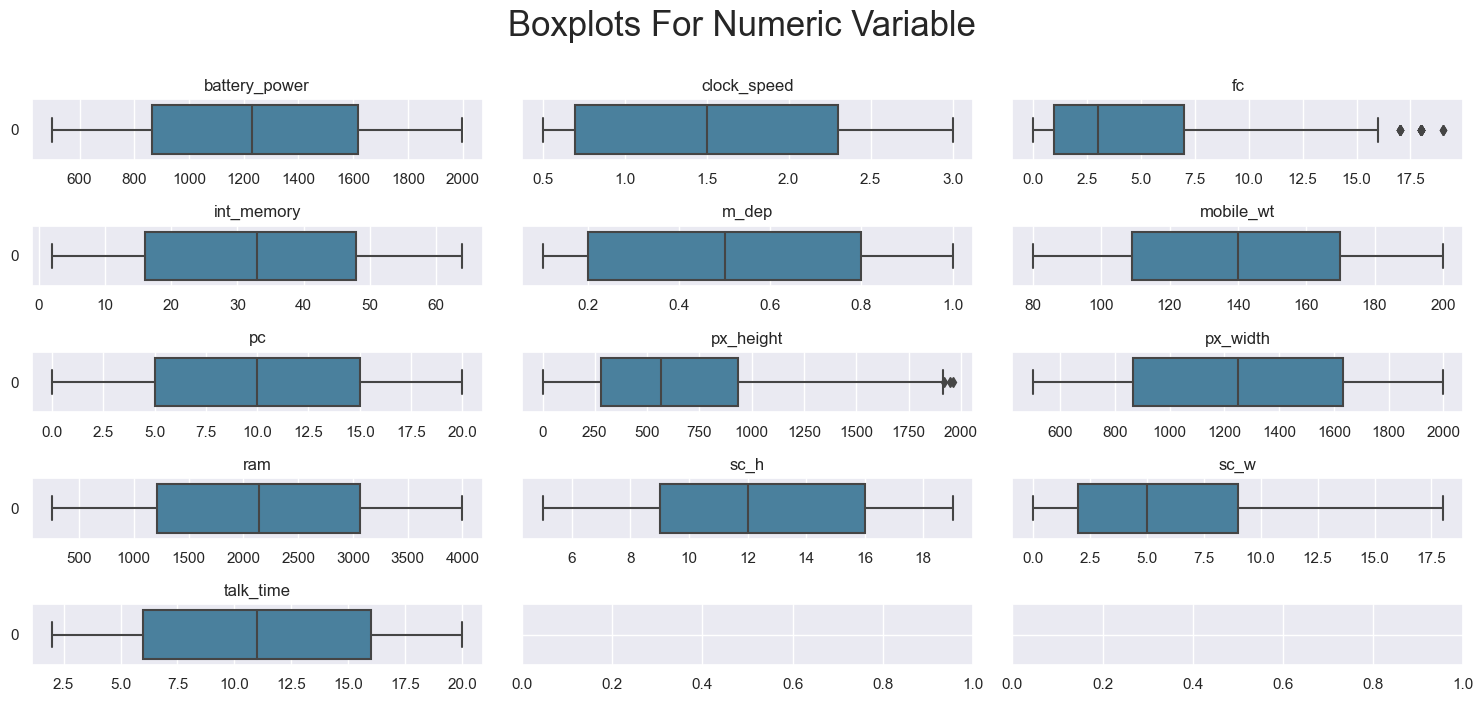

In [9]:
# Visualizing the Numerical Features by boxplots
sns.set_style('darkgrid')
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(15,7))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', color ='#3C84AB', ax=axs[i])
        axs[i].set_title(data)
        
boxplots_custom(dataset=df, columns_list=num_cols, rows=5, cols=3, suptitle='Boxplots For Numeric Variable')
plt.tight_layout()

- Hanya variabel `fc` dan `px_height` yang memiliki outliers. 

Text(0.5, 1.0, 'Distribution of Front Camera and Primary Camera')

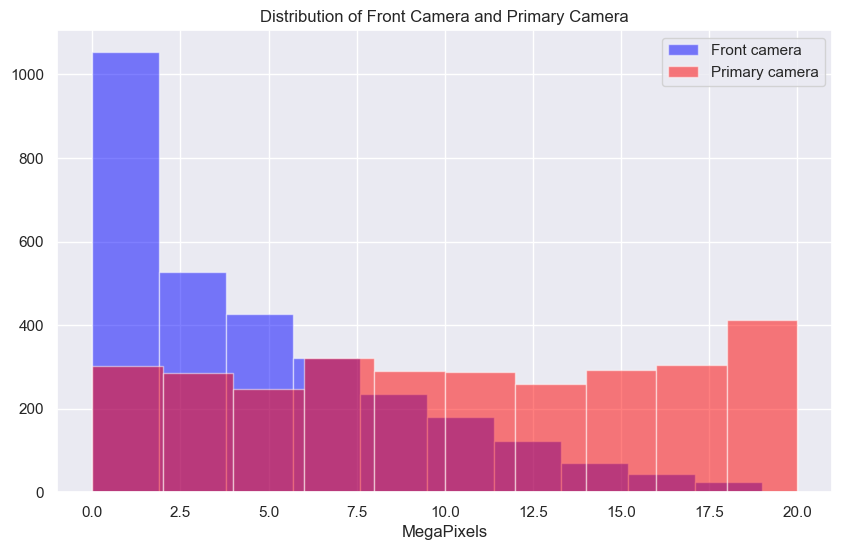

In [10]:
plt.figure(figsize=(10,6))
df['fc'].hist(alpha=0.5,color='blue',label='Front camera')
df['pc'].hist(alpha=0.5,color='red',label='Primary camera')
plt.legend()
plt.xlabel('MegaPixels') 
plt.title('Distribution of Front Camera and Primary Camera')

- Primary camera memiliki range MP yang lebih luas dari Front camera
- Distribusi ukuran MP Primary Camera lebih  merata dengan MP terbanyak ada pada 20MP
- Pada Front Camera semakin besar MP semakin sedikit frekuensi phone yang menggunakankanya

In [12]:
df['int_memory_mb'] = 1000 * df['int_memory']

In [77]:
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,int_memory_mb
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,7000
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,53000
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,41000
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,10000
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,44000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0,54000
2996,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1,13000
2997,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0,8000
2998,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0,50000


Text(0.5, 1.0, 'Distribution of Internal Memory and RAM')

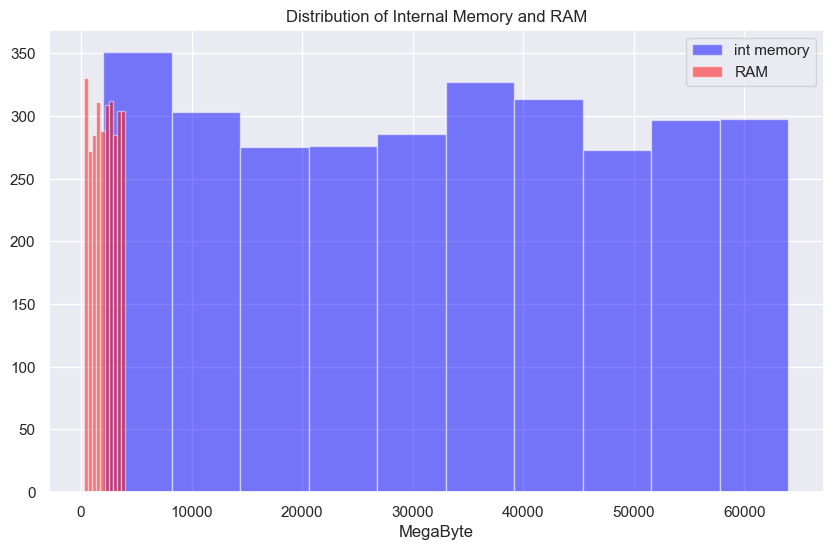

In [13]:
plt.figure(figsize=(10,6))
df['int_memory_mb'].hist(alpha=0.5,color='blue',label='int memory')
df['ram'].hist(alpha=0.5,color='red',label='RAM')
plt.legend()
plt.xlabel('MegaByte')
plt.title('Distribution of Internal Memory and RAM')

- RAM memiliki range hanya sampai dbawah 5GB
- Internal memory memiliki range sampai 60GB dengan distribusi yang cukup merata

In [18]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [19]:
df_std

array([[-0.91500521, -1.00400803,  0.81872213, ..., -1.77788854,
        -1.00400803,  0.98609664],
       [-0.50538575,  0.99600797, -1.25388924, ...,  0.56246496,
         0.99600797, -1.01409939],
       [-1.55346236,  0.99600797, -1.25388924, ...,  0.56246496,
         0.99600797, -1.01409939],
       ...,
       [-0.13009194, -1.00400803, -0.1566244 , ...,  0.56246496,
        -1.00400803, -1.01409939],
       [ 0.66626322,  0.99600797, -1.25388924, ..., -1.77788854,
         0.99600797, -1.01409939],
       [ 0.0644201 ,  0.99600797, -1.25388924, ...,  0.56246496,
        -1.00400803,  0.98609664]])

In [9]:
df_std  

array([[-0.91500521, -1.00400803,  0.81872213, ..., -1.77788854,
        -1.00400803,  0.98609664],
       [-0.50538575,  0.99600797, -1.25388924, ...,  0.56246496,
         0.99600797, -1.01409939],
       [-1.55346236,  0.99600797, -1.25388924, ...,  0.56246496,
         0.99600797, -1.01409939],
       ...,
       [-0.13009194, -1.00400803, -0.1566244 , ...,  0.56246496,
        -1.00400803, -1.01409939],
       [ 0.66626322,  0.99600797, -1.25388924, ..., -1.77788854,
         0.99600797, -1.01409939],
       [ 0.0644201 ,  0.99600797, -1.25388924, ...,  0.56246496,
        -1.00400803,  0.98609664]])

## MODELLING

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=123)
tsne_pca_results = tsne.fit_transform(df_std) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
from sklearn.decomposition import PCA

pca = PCA(random_state=123)
pca.fit(tsne_pca_results)

pca.explained_variance_ratio_

array([0.7001821, 0.2998179], dtype=float32)

Text(0, 0.5, 'Cumulative Explained Variance')

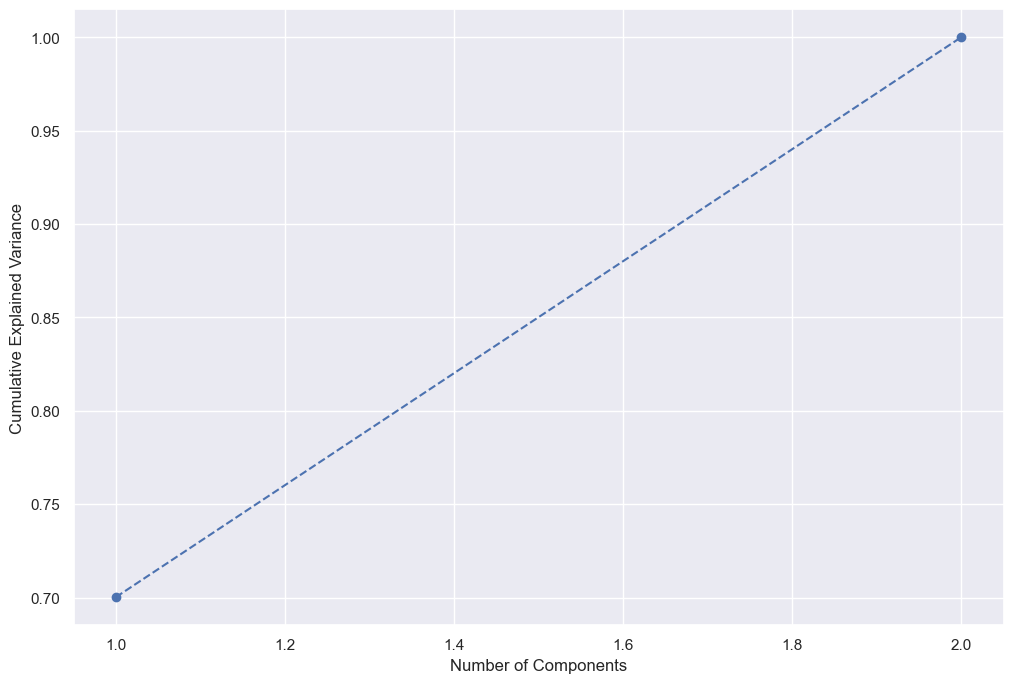

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 3), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance') 

In [24]:
pca = PCA(n_components=2)
pca_results= pca.fit_transform(df_std)
#pca_results= pca.fit(df_std)
#pca_results = pca.transform(df_std)

df_pca_components = pd.DataFrame(
    data=pca.components_.round(4),
    columns=df.columns.values,
    index=['component 1', 'component 2'])

df_pca_components

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
component 1,0.0579,-0.0439,0.0334,0.0251,0.6962,-0.0308,-0.0523,0.0472,0.0336,0.0086,0.6985,0.0269,0.0552,-0.0133,-0.0390,-0.0651,-0.0340,-0.0397,-0.0156,-0.0245
component 2,0.0416,0.0282,0.0828,0.0176,-0.0429,-0.5728,0.0316,0.0352,0.0210,-0.0308,-0.0443,-0.2163,-0.2295,-0.0559,-0.3328,-0.3521,0.0433,-0.5608,0.0342,0.0024


<AxesSubplot:>

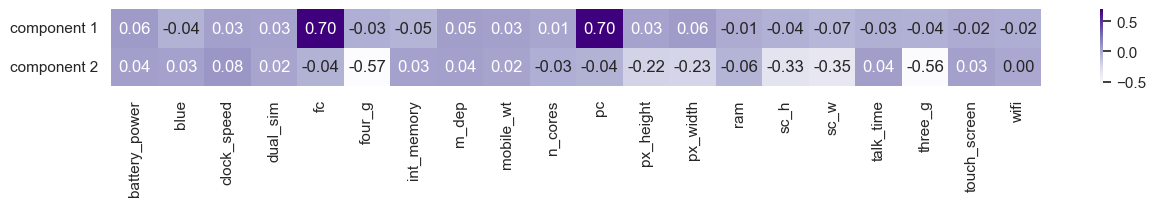

In [25]:
plt.figure(figsize=(15, 1))
sns.heatmap(df_pca_components, cmap='Purples', annot=True, fmt='.2f')

- Pada Component 1 variabel yang memiliki korelasi yang tinggi adalah `fc` dan `pc` dimana kedua variabel ini berhubungan dengan kamera pada phone. 
- Pada Component 2 variabel tidak terdapat variabel yang memiliki korelasi yang tinggi namun terdapat variabel yang memiliki korelasi menengah yaitu  `px_heigth`, `px_width`, `sc_h`, `sc_w` dimana variabel tersebut berhubungan dengan tampilan dari phone.
- Interpretasi Clustering difokuskan pada variabel yang berpengaruh pada kedua component

### K-MEANS

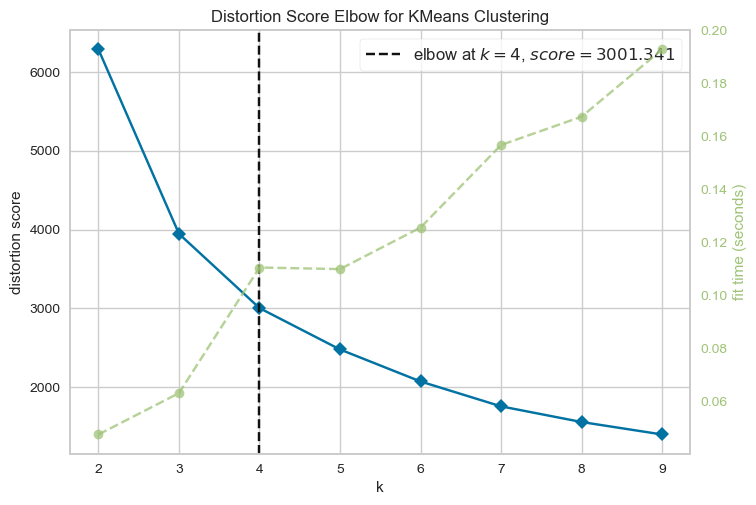

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
#!pip install yellowbrick  

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
#warnings.filterwarnings('ignore')



#Instantiate the clustering model and visualizer
km = KMeans(random_state=123)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(pca_results)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [27]:
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [28]:
nK = 12
RNDN = 123

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


silhouette scores for k clusters:
2 : 0.340
3 : 0.372
4 : 0.358
5 : 0.346
6 : 0.357
7 : 0.346
8 : 0.340
9 : 0.338
10 : 0.336
11 : 0.338
maximum silhouette score for 3 clusters:  0.372


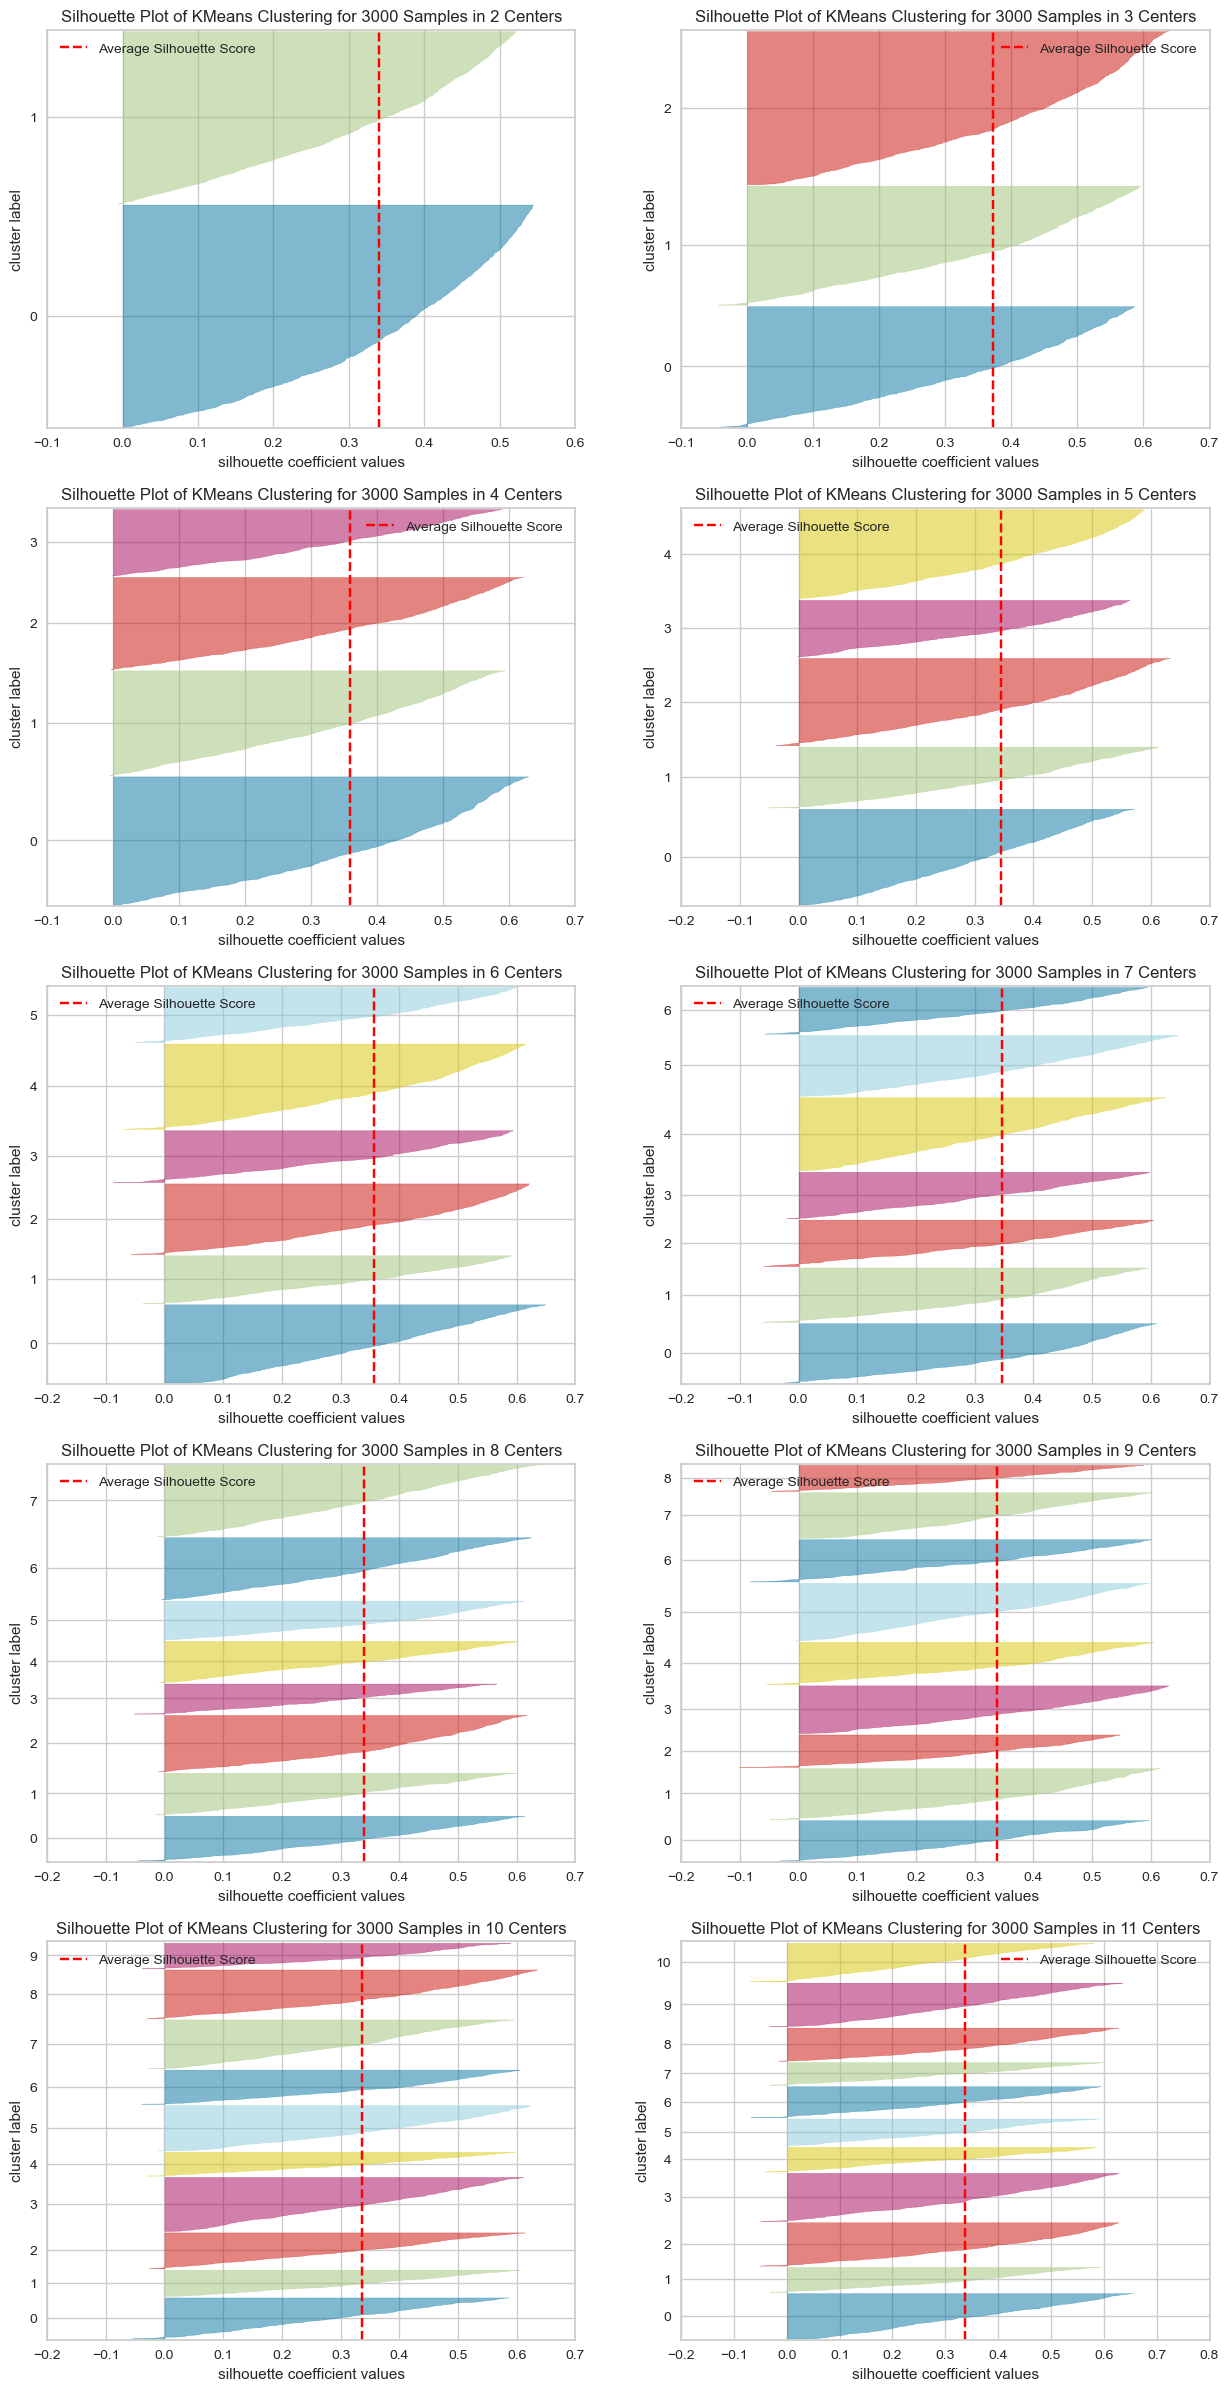

In [29]:
# silhouette score plots with Yellowbrick
dict_score = dict()
fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

for i in tqdm(range(2,nK)):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
    vis.fit(pca_results)
    vis.finalize()
    dict_score[i] = vis.silhouette_score_


print("silhouette scores for k clusters:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

In [30]:
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=123)
kmeans_pca.fit(pca_results)

KMeans(n_clusters=3, random_state=123)

In [31]:
df_segm_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_results)], axis=1)
df_segm_pca.columns.values[-2:] = ['component 1', 'component 2']
df_segm_pca['K-means PCA'] = kmeans_pca.labels_

df_segm_pca

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2,K-means PCA
0,842,0,2.2,0,1,0,7,0.6,188,2,...,2549,9,7,19,0,0,1,-1.409461,2.338378,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,2631,17,3,7,1,1,0,-1.215155,-1.470271,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,2603,11,2,9,1,1,0,-0.824755,-1.059252,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,2769,16,8,11,1,0,0,-0.716419,-0.883464,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1411,8,2,15,1,1,0,1.814093,-0.386920,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,...,2121,14,8,15,1,1,0,-0.099213,-0.837964,2
2996,609,0,1.8,1,0,0,13,0.9,186,4,...,1933,8,1,19,0,1,1,-1.257839,2.034490,1
2997,1185,0,1.4,0,1,1,8,0.5,80,1,...,1223,5,0,14,1,0,0,-0.229779,0.356128,1
2998,1533,1,0.5,1,0,0,50,0.4,171,2,...,2509,15,11,6,0,1,0,-0.622102,1.546757,1


In [32]:
df_segm_pca_analysis = df_segm_pca[['K-means PCA', 'blue']].groupby(['K-means PCA']).count()

In [33]:
df_segm_pca_analysis

,blue
K-means PCA,
0,921
1,910
2,1169


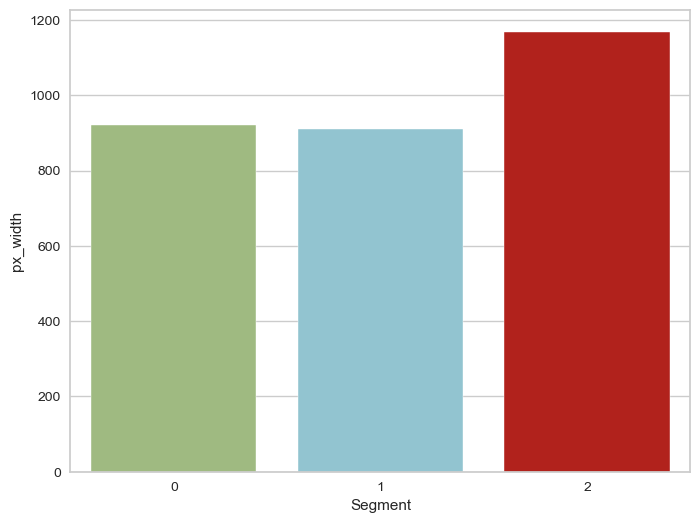

In [34]:
plt.figure(figsize=(8, 6))
s = sns.barplot(data=df_segm_pca_analysis, x=df_segm_pca_analysis.index, y='blue', palette=['g','c','r','b'])
plt.xlabel('Segment')
plt.ylabel('px_width')
plt.show()

In [35]:
pd.set_option('display.max_columns', None)
df_segm_pca_group = df_segm_pca.groupby('K-means PCA').mean().round(3)
df_segm_pca_group

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2
K-means PCA,,,,,,,,,,,,,,,,,,,,,,
0,1274.678,0.466,1.578,0.523,9.134,0.600,31.155,0.524,140.554,4.429,16.112,661.954,1288.888,2108.803,12.378,5.617,10.815,0.866,0.510,0.474,1.467,-0.374
1,1250.329,0.518,1.584,0.518,2.866,0.046,33.563,0.517,140.702,4.373,8.229,558.065,1134.789,2094.880,10.647,4.113,11.384,0.360,0.513,0.514,-0.360,1.443
2,1209.384,0.518,1.446,0.499,1.875,0.800,32.942,0.486,139.025,4.543,6.467,684.207,1302.892,2171.835,13.275,6.787,10.938,0.986,0.487,0.527,-0.876,-0.829


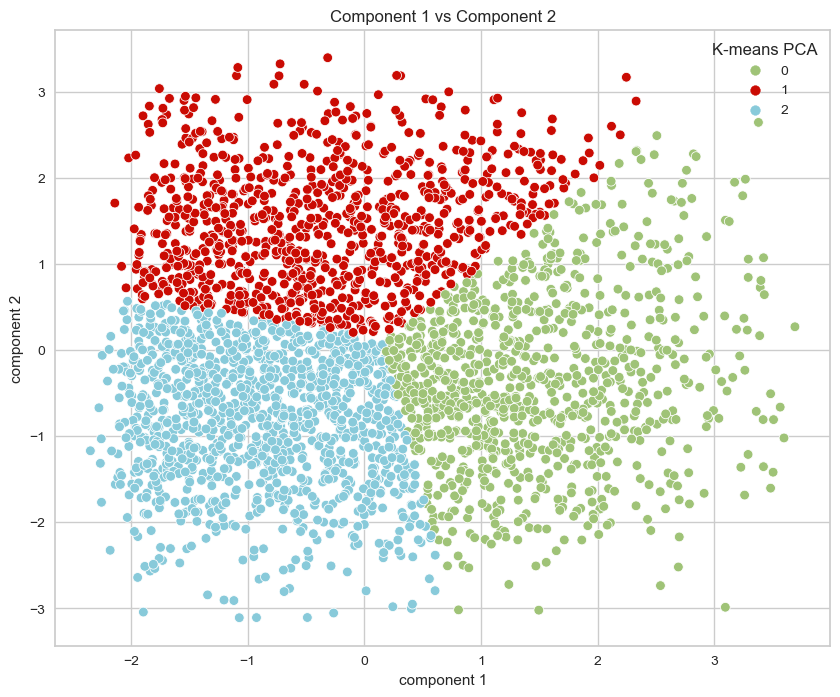

In [36]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_segm_pca['component 1'],
    y=df_segm_pca['component 2'],
    hue=df_segm_pca['K-means PCA'],
    palette=['g','r','c']
)
# plt.scatter(2.35, 2 , s=60000, facecolors='none', edgecolors='g' )
# plt.scatter(-1.2, 2 , s=60000, facecolors='none', edgecolors='r' )
# plt.scatter(-1, -1 , s=30000, facecolors='none', edgecolors='c' )
# plt.scatter(1.2, -1 , s=40000, facecolors='none', edgecolors='m' )
# plt.scatter(1.2, -1 , s=40000, facecolors='none', edgecolors='y' )

plt.title('Component 1 vs Component 2')
plt.show()

### HIERARCHY CLUSTERING

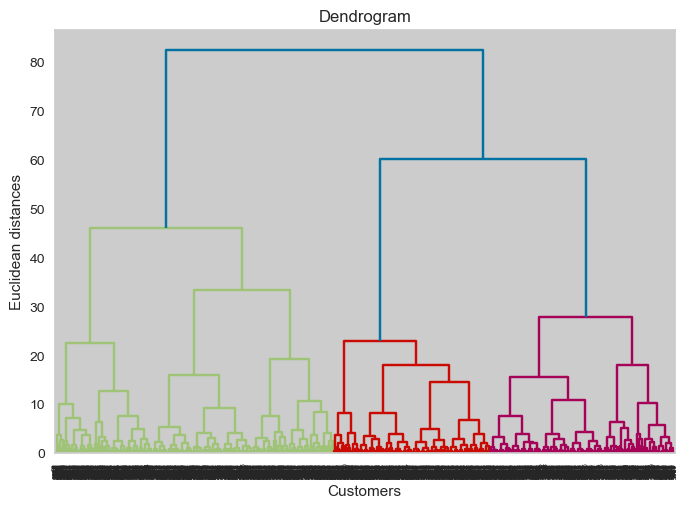

In [31]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(pca_results, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [32]:
from sklearn.cluster import AgglomerativeClustering

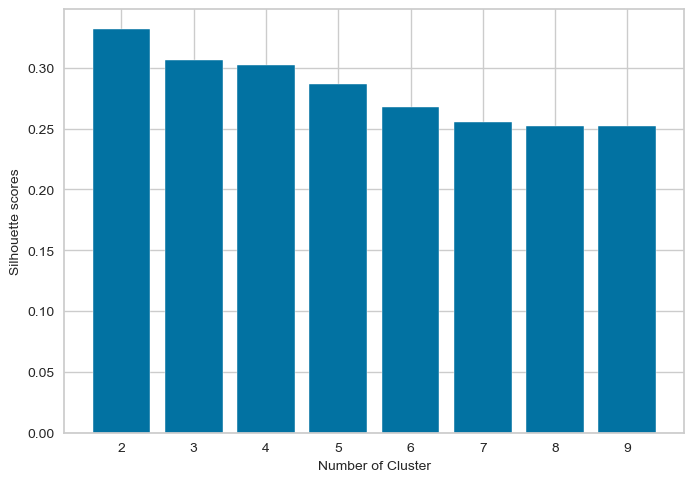

In [33]:
silhouette_scores = []

for n_cluster in range(2,10):
    silhouette_scores.append(silhouette_score(pca_results, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(pca_results)))

plt.bar(range(2,10), silhouette_scores)
plt.xlabel('Number of Cluster', fontsize=10)
plt.ylabel('Silhouette scores', fontsize=10)
plt.show()

In [98]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(pca_results)

In [35]:
y_hc

array([2, 1, 1, ..., 0, 2, 0], dtype=int64)

In [99]:
df_hirar = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_results)], axis=1)
df_hirar.columns.values[-2:] = ['component 1', 'component 2']
df_hirar['Hirar PCA'] = y_hc

df_hirar

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,int_memory_mb,component 1,component 2,Hirar PCA
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,7000,-1.530619,2.441165,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,53000,-1.132924,-1.714455,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,41000,-0.793514,-1.107301,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,10000,-0.615276,-0.626510,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,44000,2.052932,-0.447147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0,54000,0.006358,-0.914713,0
2996,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1,13000,-1.415029,2.016197,0
2997,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0,8000,-0.116755,0.571646,0
2998,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0,50000,-0.675548,1.189896,0


In [100]:
df_hirar_analysis = df_hirar[['Hirar PCA', 'blue']].groupby(['Hirar PCA']).count()

In [101]:
df_hirar_analysis

,blue
Hirar PCA,
0,1682
1,1318


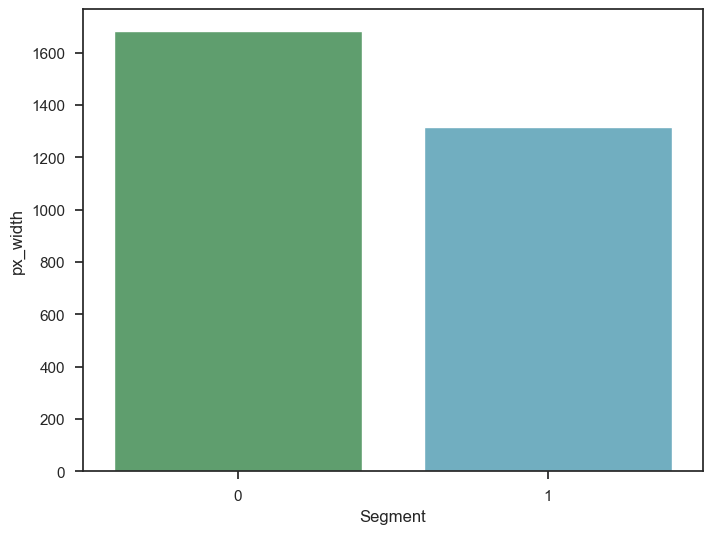

In [102]:
plt.figure(figsize=(8, 6))
s = sns.barplot(data=df_hirar_analysis, x=df_hirar_analysis.index, y='blue', palette=['g','c','r','b'])
plt.xlabel('Segment')
plt.ylabel('px_width')
plt.show()

In [103]:
pd.set_option('display.max_columns', None)
df_segm_pca_analysis = df_segm_pca.groupby('K-means PCA').mean().round(3)
df_segm_pca_analysis

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2
K-means PCA,,,,,,,,,,,,,,,,,,,,,,
0,1217.746,0.494,1.439,0.522,2.320,0.773,34.603,0.498,136.980,4.463,7.376,819.964,1425.684,2234.891,14.322,8.007,10.965,0.957,0.501,0.563,-0.630,1.200
1,1278.497,0.481,1.561,0.507,9.120,0.555,30.419,0.522,142.862,4.498,16.062,597.825,1233.267,2079.808,11.920,5.088,10.836,0.808,0.496,0.463,1.498,-0.070
2,1231.337,0.528,1.582,0.507,2.112,0.227,32.649,0.502,140.238,4.413,6.897,509.092,1096.045,2075.633,10.499,3.883,11.279,0.534,0.509,0.495,-0.757,-1.045


In [104]:
pd.set_option('display.max_columns', None)
df_hirar_analysis_group = df_hirar.groupby('Hirar PCA').mean().round(3)
df_hirar_analysis_group

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,int_memory_mb,component 1,component 2
Hirar PCA,,,,,,,,,,,,,,,,,,,,,,,
0,1202.916,0.512,1.510,0.512,1.736,0.472,33.595,0.492,138.611,4.446,6.033,625.713,1222.681,2169.684,12.344,5.873,11.211,0.723,0.504,0.530,33594.530,-0.902,0.097
1,1291.535,0.489,1.552,0.512,7.809,0.558,31.289,0.526,141.780,4.470,14.977,656.212,1279.404,2077.402,12.022,5.290,10.812,0.807,0.499,0.478,31289.074,1.151,-0.123


### PERBANDINGAN MODEL 

#### HIERARCY

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


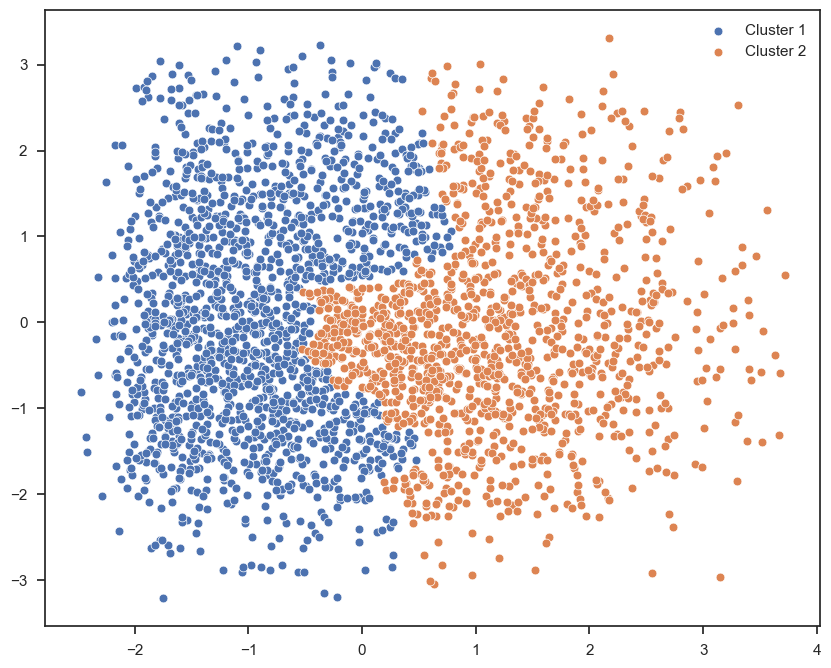

In [105]:
plt.figure(figsize=(10, 8))
sns.scatterplot(pca_results[y_hc == 0, 0], pca_results[y_hc == 0, 1], s = 40, palette='g',  label = 'Cluster 1')
sns.scatterplot(pca_results[y_hc == 1, 0], pca_results[y_hc == 1, 1], s = 40, palette='b', label = 'Cluster 2')
# sns.scatterplot(pca_results[y_hc == 2, 0], pca_results[y_hc == 2, 1], s = 40, palette='y', label = 'Cluster 3')
# sns.scatterplot(pca_results[y_hc == 3, 0], pca_results[y_hc == 3, 1], s = 40, palette='y', label = 'Cluster 4')
plt.legend()
plt.show()

#### K-MEANS

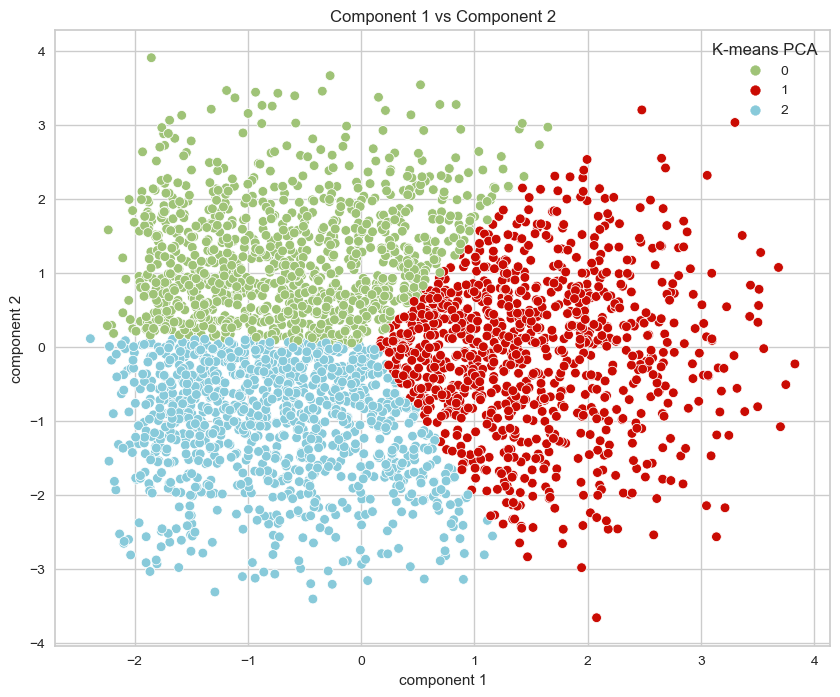

In [43]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_segm_pca['component 1'],
    y=df_segm_pca['component 2'],
    hue=df_segm_pca['K-means PCA'],
    palette=['g','r','c']
)
# plt.scatter(2.35, 2 , s=60000, facecolors='none', edgecolors='g' )
# plt.scatter(-1.2, 2 , s=60000, facecolors='none', edgecolors='r' )
# plt.scatter(-1, -1 , s=30000, facecolors='none', edgecolors='c' )
# plt.scatter(1.2, -1 , s=40000, facecolors='none', edgecolors='m' )
# plt.scatter(1.2, -1 , s=40000, facecolors='none', edgecolors='y' )

plt.title('Component 1 vs Component 2')
plt.show()

In [106]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(pca_results, kmeans_pca.labels_) 

0.9335274448001977

In [107]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(pca_results, y_hc)

1.2829218265766011

In [46]:
df_segm_pca

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2,K-means PCA
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,-1.493603,-2.393030,2
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,-1.172704,1.862061,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,-0.816541,1.216908,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,-0.804884,1.008636,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,2.015765,0.207237,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0,0.207590,0.686709,0
2996,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1,-1.714158,-1.381493,2
2997,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0,-0.010466,-1.058061,2
2998,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0,-0.677768,-1.200811,2


In [37]:
pd.set_option('display.max_columns', None)
df_segm_pca_group = df_segm_pca.groupby('K-means PCA').mean().round(3)
df_segm_pca_group 

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2
K-means PCA,,,,,,,,,,,,,,,,,,,,,,
0,1274.678,0.466,1.578,0.523,9.134,0.600,31.155,0.524,140.554,4.429,16.112,661.954,1288.888,2108.803,12.378,5.617,10.815,0.866,0.510,0.474,1.467,-0.374
1,1250.329,0.518,1.584,0.518,2.866,0.046,33.563,0.517,140.702,4.373,8.229,558.065,1134.789,2094.880,10.647,4.113,11.384,0.360,0.513,0.514,-0.360,1.443
2,1209.384,0.518,1.446,0.499,1.875,0.800,32.942,0.486,139.025,4.543,6.467,684.207,1302.892,2171.835,13.275,6.787,10.938,0.986,0.487,0.527,-0.876,-0.829


In [38]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1241.849000,0.502000,1.528467,0.512000,4.404000,0.510000,32.581667,0.507000,140.003000,4.456333,9.962333,639.112333,1247.601667,2129.141333,12.202667,5.616667,11.035667,0.759667,0.502000,0.507000
std,437.063804,0.500079,0.820358,0.499939,4.383742,0.499983,18.152810,0.285969,35.213809,2.289361,6.073923,440.202998,434.666168,1085.694231,4.251151,4.322494,5.474400,0.427357,0.500079,0.500034
min,500.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,863.750000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,2.000000,5.000000,277.750000,865.000000,1212.750000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000
50%,1232.000000,1.000000,1.500000,1.000000,3.000000,1.000000,33.000000,0.500000,140.000000,4.000000,10.000000,564.000000,1248.000000,2147.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000
75%,1619.000000,1.000000,2.300000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,6.000000,15.000000,932.500000,1634.000000,3065.250000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000
max,1999.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000


In [39]:
def highlight_max_min(s):
   
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: red' if v else 'background-color: lightgreen' if is_min[i] else '' for i,v in enumerate(is_max)]

# Calculate the mean value for each feature within each cluster
profil = df_segm_pca.groupby('K-means PCA').mean().round(2).T

# Highlight the maximum and minimum values in each column
profil_styled = profil.style.apply(highlight_max_min, axis=1)

# Display the styled DataFrame
profil_styled

K-means PCA,0,1,2
battery_power,1274.680000,1250.330000,1209.380000
blue,0.470000,0.520000,0.520000
clock_speed,1.580000,1.580000,1.450000
dual_sim,0.520000,0.520000,0.500000
fc,9.130000,2.870000,1.880000
four_g,0.600000,0.050000,0.800000
int_memory,31.160000,33.560000,32.940000
m_dep,0.520000,0.520000,0.490000
mobile_wt,140.550000,140.700000,139.020000
n_cores,4.430000,4.370000,4.540000


1. Cluster 0 :Picture Making
- Mobilephone yang paling cocok dengan user yang menyukai selfie dan fotografi karena phone jenis ini menyajikan kamera depan dan kamera utama dengan resolusi kamera diatas rata-rata dan tertinggi dibanding kluster lain.
2. Cluster 2: Relived and Clear
- Mobilephone dengan tampilan yang paling memanjakan pengguna karena memiliki ukuran layar paling besar dan diatas rata-rata dibading kluster lain sehingga pengguna dapat melihat layar secara legah (Relived). Tidak hanya itu mobilephone jenis ini memiliki ketajaman layar HD dimana merupakan tertinggi dibanding kluster lain sehingga user dapat melihat tampilan dilayar mobilephone secara jelas (Clear).
3. Cluster 1 :Low Spec
- Mobilephone jenis ini memiliki ukuran layar, resolusi layar, dan resouli kamera dibawah rata-rata dan yang terendah dibanding cluster lain dan tidak memiliki keunggulan yang mencolok (Low Specification).

In [41]:
df_segm_pca['Segment'] = df_segm_pca['K-means PCA'].map({
    2: 'Relived and Clear',
    0: 'Picture Making',
    1: 'Low Spec'
})
df_segm_pca

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,component 1,component 2,K-means PCA,Segment
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,-1.409461,2.338378,1,Low Spec
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,-1.215155,-1.470271,2,Relived and Clear
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,-0.824755,-1.059252,2,Relived and Clear
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,-0.716419,-0.883464,2,Relived and Clear
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1.814093,-0.386920,0,Picture Making
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0,-0.099213,-0.837964,2,Relived and Clear
2996,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1,-1.257839,2.034490,1,Low Spec
2997,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0,-0.229779,0.356128,1,Low Spec
2998,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0,-0.622102,1.546757,1,Low Spec


Text(0, 0.5, 'common X')

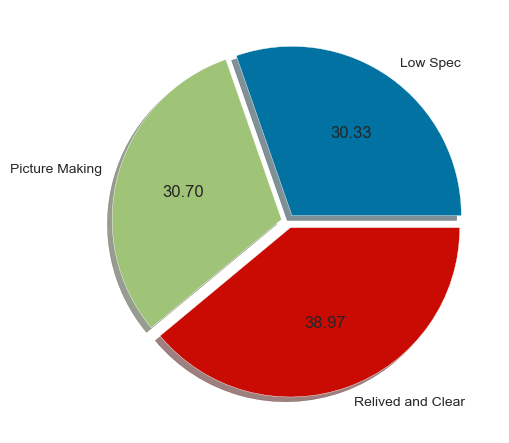

In [59]:
df_segm_pca.groupby('Segment').size().plot(kind='pie', autopct='%.2f',  explode=[0.04, 0.04, 0.04], shadow=True)
plt.ylabel("common X", visible=False)
# fig.update_yaxes(title='y', visible=False, showticklabels=False)

- Berdasarkan piechart dapat dilihat bahwa pembagi data hampir balanced dengan proporsi tertinggi ada pada cluster `Relived and Clear`
- Proposi antara cluster `Picture Making` dan `Low Spec` seimbang.

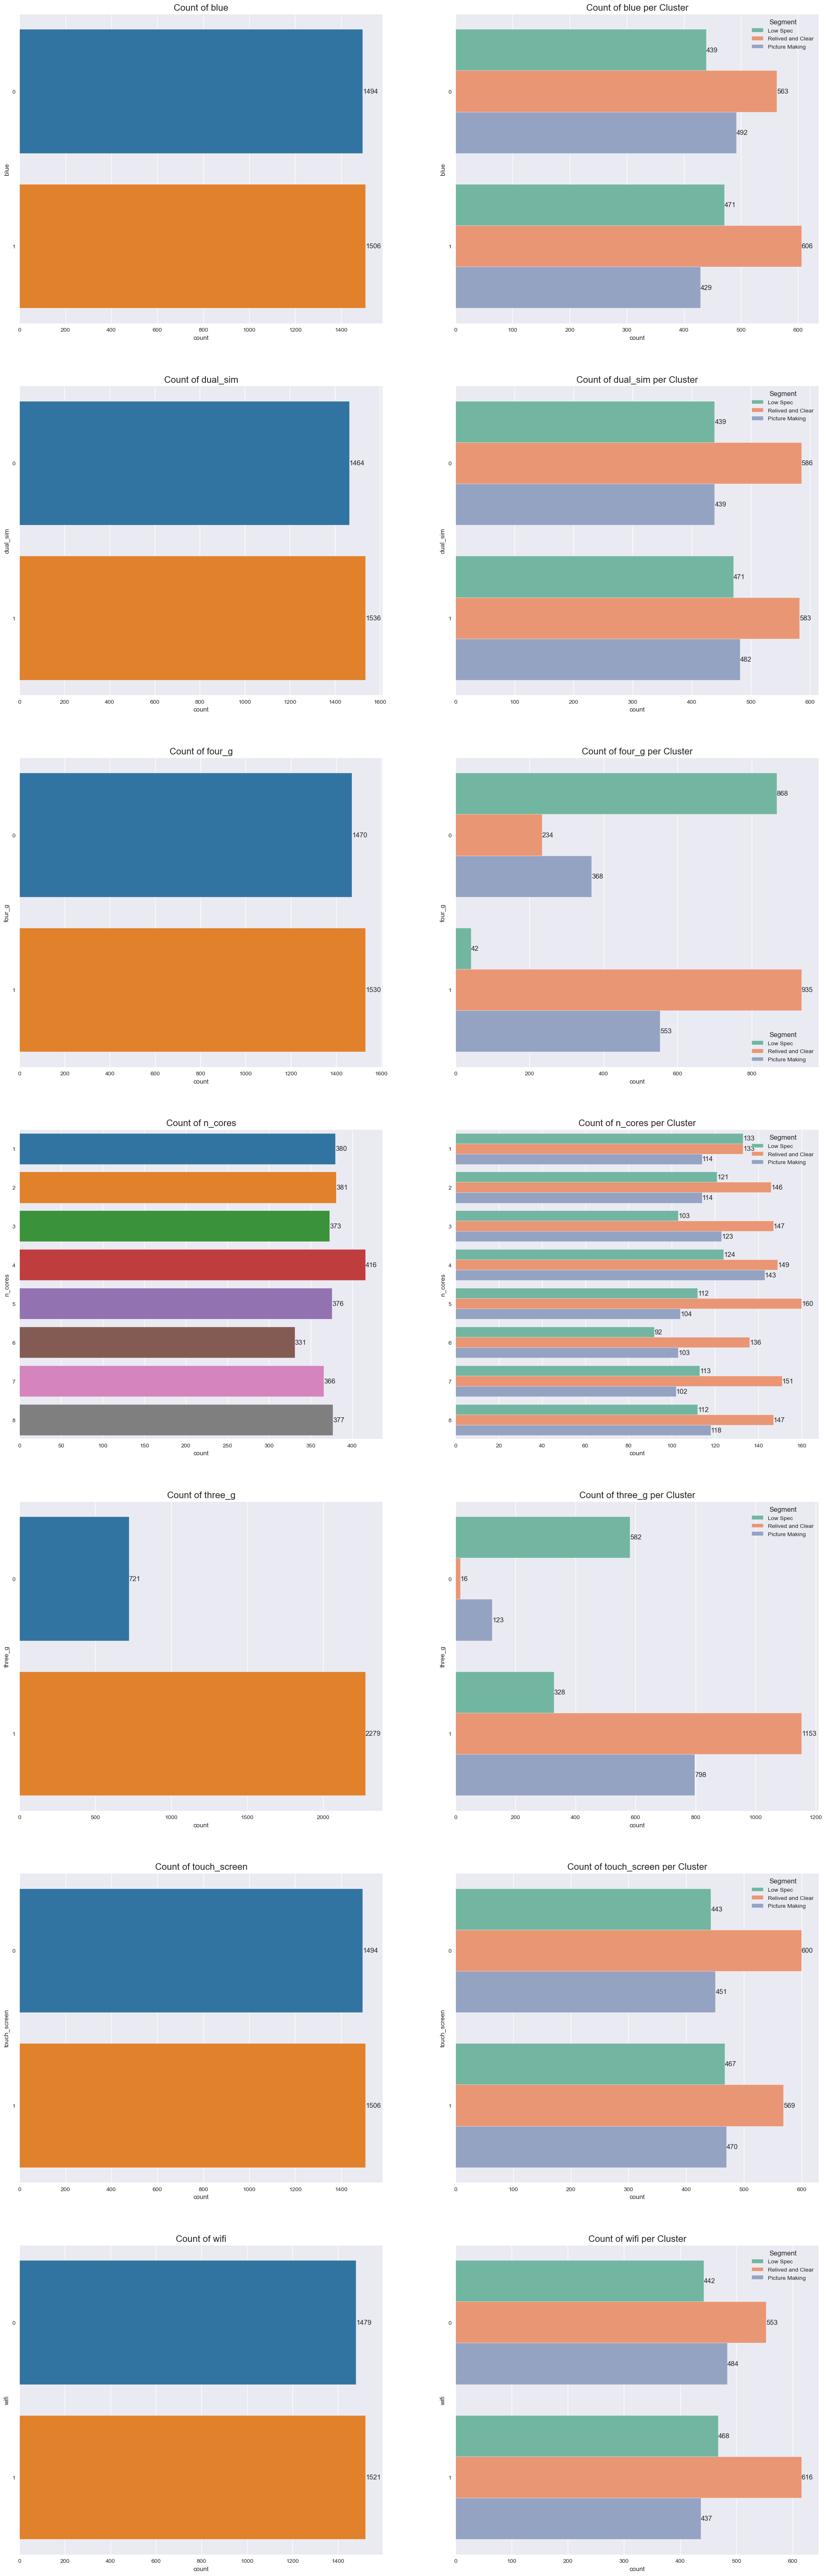

In [47]:
fig, axes = plt.subplots(7,2, figsize=(25,80))
sns.set_style('darkgrid')
idx = 0
for col in categorical_columns:
    sns.countplot(data= df_segm_pca, y=col, palette='tab10', orient='h',
                  ax=axes[idx][0]).set_title(f'Count of {col}', fontsize='16')
    for container in axes[idx][0].containers:
        axes[idx][0].bar_label(container)
    sns.countplot(data= df_segm_pca, y=col, palette='Set2', orient='h',  hue='Segment',
                  ax=axes[idx][1]).set_title(f'Count of {col} per Cluster', fontsize='16')
    for container in axes[idx][1].containers:
        axes[idx][1].bar_label(container)
    idx +=1
plt.show()

- Bluetooth
- Terdapat lebih banyak mobilephone yang memiliki bluetooth dibandingkan tidak namun proporsi keduanya sangat tipis.
- Pada mobilephone yang tidak memiliki bluetooth cluster dengan frekuensi tertinggi adalah `Relived and Clear`.
- Pada mobilephone yang memiliki bluetooth cluster dengan frekuensi tertinggi adalah `Relived and Clear` juga.

- Dual Sim
- Terdapat lebih banyak mobilephone yang memiliki dualsim dibandingkan tidak namun proporsi keduanya tidak jauh berbeda.
- Pada mobilephone yang tidak memiliki dualsim, cluster dengan frekuensi tertinggi adalah `Relived and Clear`.
- Pada mobilephone yang memiliki dualsim cluster dengan frekuensi tertinggi adalah `Relived and Clear` juga.

- 4G
- Terdapat lebih banyak mobilephone yang memiliki 4G dibandingkan tidak namun proporsi keduanya tidak jauh berbeda.
- Pada mobilephone yang tidak memiliki 4G, cluster dengan frekuensi tertinggi adalah `Low Spec`.
- Pada mobilephone yang memiliki 4G, cluster dengan frekuensi tertinggi adalah `Relived and Clear`.

- Total of Core Processor
- Jumlah processor terbanyak adalah 4 namun distribusi frekuensi antar jumlah processor tidak jauh berbeda.
- Pada semua jumlah processor cluster dengan frekuensi tertinggi adalah `Relived and Clear`.

- 3G
- Terdapat lebih banyak mobilephone yang memiliki 3G dibandingkan tidak dimana proporsi keduanya berbeda jauh.
- Pada mobilephone yang tidak memiliki 3G, cluster dengan frekuensi tertinggi adalah `Low Spec`.
- Pada mobilephone yang memiliki 3G, cluster dengan frekuensi tertinggi adalah `Relived and Clear`.


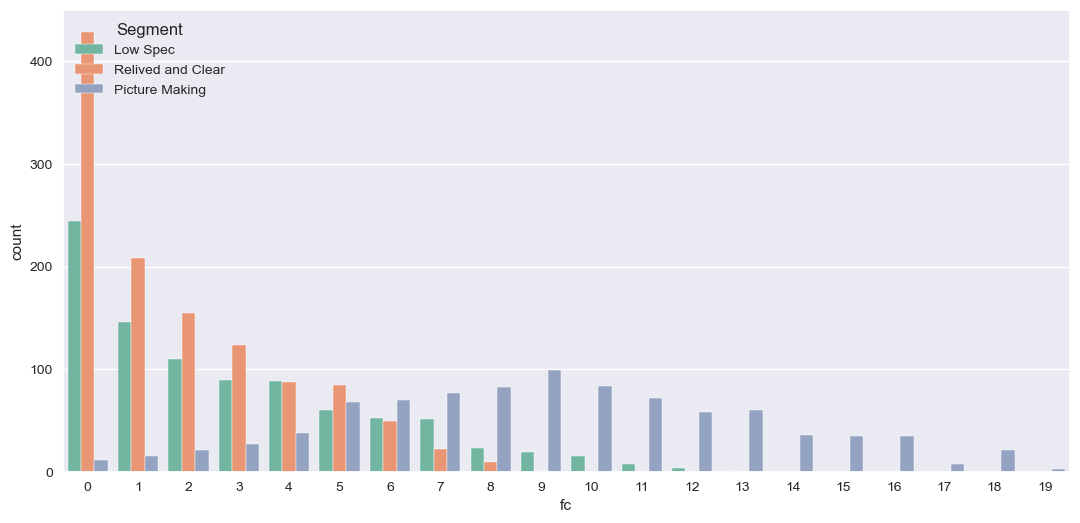

In [52]:
# fc based on price_range
plt.figure(figsize = (13,6))
sns.countplot(x = df_segm_pca['fc'], hue ="Segment", data=df_segm_pca, palette='Set2') 
plt.show()

- Pada cluster `Low Spec` semakin tinggi MP front camera semakin berkurang frekuensi mobilephonenya dimana yang tertinggi pada 0MP.
- Pada cluster `Relived and Clear` semakin tinggi MP front camera semakin berkurang frekuensi mobilephonenya dimana yang tertinggi ada pada 0MP.
- Pada cluster `Picture Making` memiliki semua ukuran MP front camera dengan MP terbanyak adalah 9MP.

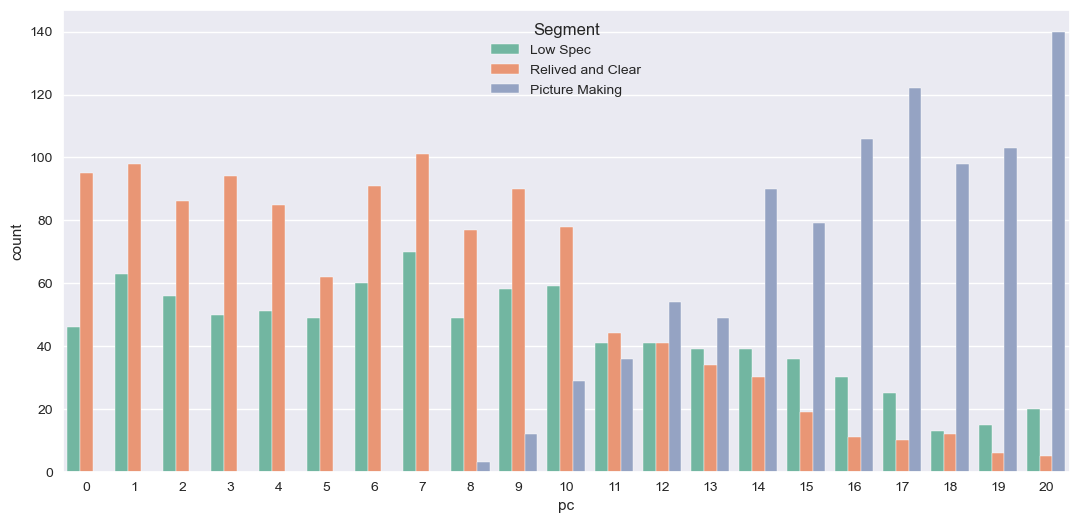

In [53]:
# fc based on price_range
plt.figure(figsize = (13,6))
sns.countplot(x = df_segm_pca['pc'], hue ="Segment", data=df_segm_pca, palette='Set2') 
plt.show()

- Pada cluster `Low Spec` distribusi antar MP cenderung naik turun dimana frekuensi tertinggi ada pada 7MP.
- Pada cluster `Relived and Clear` semakin tinggi MP front camera semakin berkurang frekuensi mobilephonenya dengan frekuensi tertinggi ada pada 7MP.
- Pada cluster `Picture Making` tidak memiliki ukuran MP dibawah 7MP dan semakin tinggi MP frekuensinya makin tinggi dengan yang tertinggi adalah 20MP.

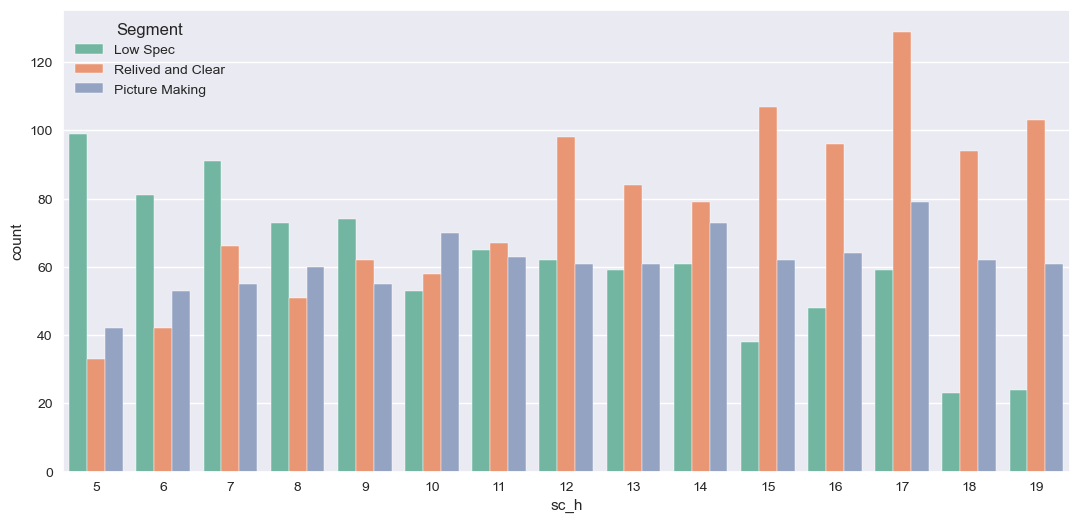

In [54]:
# fc based on price_range
plt.figure(figsize = (13,6))
sns.countplot(x = df_segm_pca['sc_h'], hue ="Segment", data=df_segm_pca, palette='Set2') 
plt.show()

- Pada cluster `Low Spec` distribusi antar tinggi layar cenderung turun dimana frekuensi tertinggi ada pada 5CM.
- Pada cluster `Relived and Clear` distribusi antar tinggi layar cenderung naik turun dimana frekuensi tertinggi ada pada 17CM.
- Pada cluster `Picture Making` distribusi antar tinggi layar cenderung naik turun dimana frekuensi tertinggi ada pada 17CM.

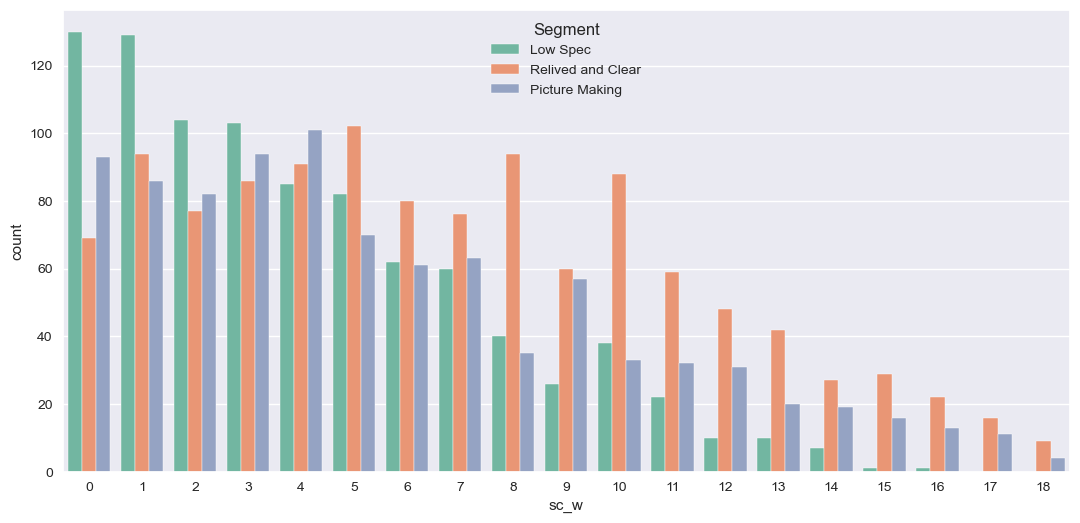

In [55]:
# fc based on price_range
plt.figure(figsize = (13,6))
sns.countplot(x = df_segm_pca['sc_w'], hue ="Segment", data=df_segm_pca, palette='Set2') 
plt.show()

- Pada cluster `Low Spec` distribusi antar lebar layar cenderung turun dimana frekuensi tertinggi ada pada 0CM.
- Pada cluster `Relived and Clear` distribusi antar lebar layar cenderung turun dimana frekuensi tertinggi ada pada 5CM.
- Pada cluster `Picture Making` distribusi antar lebar layar cenderung turun dimana frekuensi tertinggi ada pada 4CM.

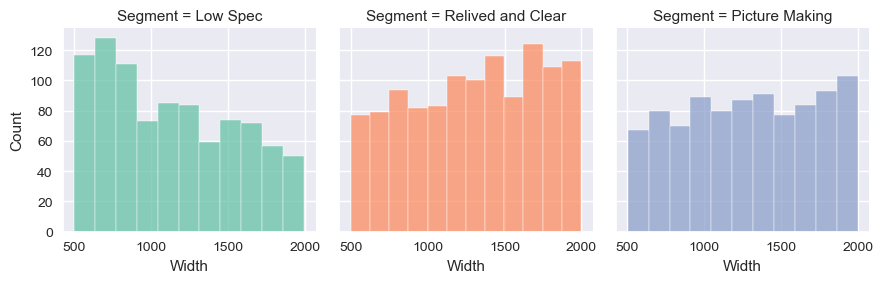

In [56]:
g = sns.FacetGrid(df_segm_pca, col="Segment", hue="Segment", palette='Set2' )
# g.map(sns.scatterplot, "px_height", "px_width")
g.map(sns.histplot, 'px_width')
g.set_axis_labels("Width", "Count")
plt.show()

- Pada cluster `Low Spec` distribusi lebar resolusi layar cenderung turun ketika resolusi makin tinggi.
- Pada cluster `Relived and Clear` distribusi lebar resolusi layar cenderung naik ketika resolusi makin tinggi.
- Pada cluster `Picture Making` distribusi lebar resolusi layar cenderung naik ketika resolusi makin tinggi.

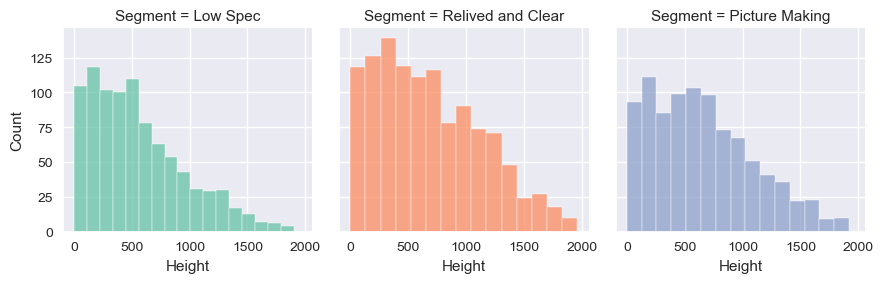

In [57]:
g = sns.FacetGrid(df_segm_pca, col="Segment", hue="Segment", palette='Set2' )
# g.map(sns.scatterplot, "px_height", "px_width")
g.map(sns.histplot, 'px_height')
g.set_axis_labels("Height", "Count")
plt.show()

- Pada ketiga cluster makin besar tinggi resolusi layar frekuensi mobilephone semkain rendah.

### Kesimpulan dan Saran

### Kesimpulan
1. Berdasarkan Davies Bouldin Score model yang terbaik antara K-Means dan Hierarcical adalah K-means karena model ini menghasilkan Davies Bouldin Score yang lebih rendah. 
2. Berdasarkan hasil clustering menggunakan K-Means data dibagi menjadi 3 cluster.
3. Dilihat dari nilai rata-rata antara kluster pada tiap variabel dipilih variabel dengan perbandingan antar cluster yang memiliki range yang jauh dimana hal ini menunjukkan pembeda yang jelas antar cluster. Variabel tersebut adalah `fc` , `pc`, `px_heigth`, `px_width`, `sc_h`, `sc_w`.
4. Didasarkan pada variabel tersebut cluster dikelompok berdasarkan spesifikasi unggulan yang dimiliki dimana cluster 0 unggul pada kamera (Picture Making) , cluster 2 unggul pada tampilan (Relived and Clear), sedangkan cluster 1 tidak unggul pada keduanya (Low Spec).
5. Mobile phone dikatakan unggul dalam kamera jika memiliki front camera disekitaran 9MP atau lebih dan primary camera disekitaran 16MP atau lebih.
6. Mobile phone dikatakan unggul dalam tampilan jika memiliki besar tinggi resolusi disekitaran 632px atau lebih, lebar resolusi disekitaran 1300px atau lebih, tinggi layar disekitaran 13 cm atau lebih , dan lebar layar disektiran 6cm atau lebih.

### Saran
Cluster yang dibentuk dapat dijadikan referensi ketika user mempertimbangkan membeli mobilephone dimana user bisa tahu apakah mobilephone yang ingin dibeli unggul pada kamera atau unggul pada tampilan luar atau unggul pada keduanya atau tidak unggul pada keduanya.